<a href="https://colab.research.google.com/github/mallang327/EEE4178-Hands-On/blob/main/Day3_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Look inside CNN**



* MNIST



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

1. Define Hyper-parameters and pre-set device on cuda

In [2]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")
# Adjust Dataset classes and channels
num_classes = 10
in_channel = 1

# Hyper-parameters
batch_size = 50
max_pool_kernel = 2
learning_rate = 0.0001
num_epochs = 5

device: cuda


2. Load Data

In [3]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

test_data = torchvision.datasets.MNIST(root='./datasets',
                                       train=False,
                                       transform=transforms.ToTensor(),
                                       download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



3. Define Dataloader

In [30]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)             # torch 의 data loader를 그대로 불러와 사용

4. Define Model

In [5]:
class ConvNetStep(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNetStep, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(num_features=16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel)
    )
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=num_classes)

  def forward1(self, x):
    x = self.layer1(x)
    return x
  
  def forward2(self, x):
    x = self.layer2(x)
    return x

  def forward3(self, x):
    x = x.reshape(x.size(0),-1)
    return self.fc1(x)

  def forward4(self, x):
    return self.fc2(x)

  def forward(self, x):    # 실제 학습 시에는 이 함수만 사용
    x = self.layer1(x)
    x = self.layer2(x)

    x = F.relu(x)
    x = x.reshape(x.size(0),-1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = ConvNetStep()

4.1 Inside CNN

4.1.1 Row Image (MNIST)

In [6]:
def image_show(tensor_image):
  image = tensor_image.reshape(tensor_image.size()[1], tensor_image.size()[2])    # width x height
  imshow(image, cmap='gray')

images, labels = next(iter(train_loader))
image1, label1 = images[0], labels[0]
image2, label2 = images[1], labels[1]

Text(0.5, 1.0, 'tensor(9)')

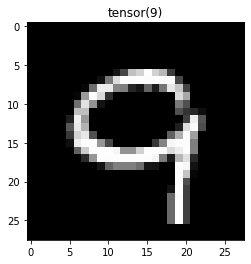

In [7]:
image_show(image1)
plt.title(label1)

Text(0.5, 1.0, 'tensor(0)')

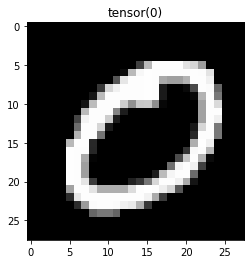

In [8]:
image_show(image2)
plt.title(label2)

4.1.2 After 1st convolution layer

In [10]:
model.eval()
output1 = model.forward1(images)
print(f"{images.size()} --> {output1.size()}")

torch.Size([50, 1, 28, 28]) --> torch.Size([50, 16, 14, 14])


In [11]:
image1, image2 = output1[0], output1[1]
print(image1.size(), image2.size())

torch.Size([16, 14, 14]) torch.Size([16, 14, 14])


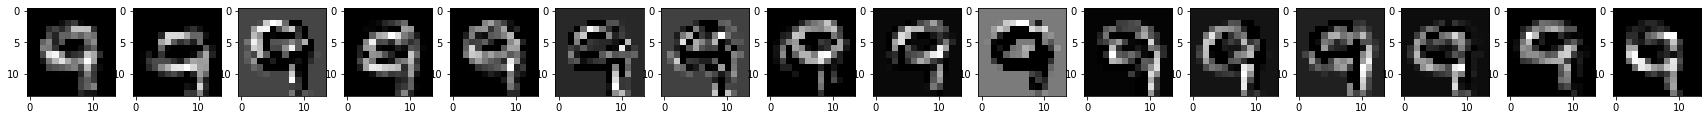

In [12]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image1)):
  plt.subplot(1,len(image1),i+1)
  plt.imshow(image1[i].detach().numpy(), cmap='gray')

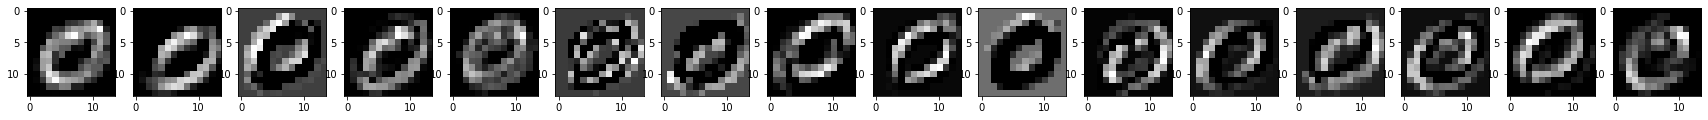

In [13]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image2)):
  plt.subplot(1,len(image2),i+1)
  plt.imshow(image2[i].detach().numpy(), cmap='gray')

4.1.3 After 2nd convolution layer

In [14]:
output2 = model.forward2(output1)
print(f"{output1.size()} --> {output2.size()}")

torch.Size([50, 16, 14, 14]) --> torch.Size([50, 32, 7, 7])


In [15]:
image1, image2 = output2[0], output2[1]

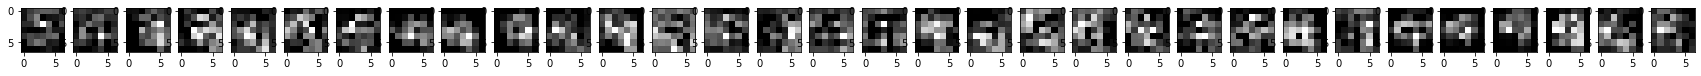

In [16]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image1)):
  plt.subplot(1,len(image1),i+1)
  plt.imshow(image1[i].detach().numpy(), cmap='gray')

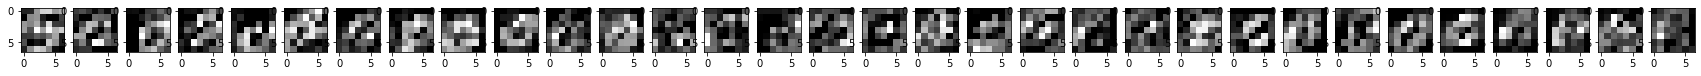

In [17]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image2)):
  plt.subplot(1,len(image2),i+1)
  plt.imshow(image2[i].detach().numpy(), cmap='gray')

4.1.4 After 3rd Fully Connected Layer

In [18]:
output3 = model.forward3(output2)
print(f"{output2.size()} --> {output3.size()}")

torch.Size([50, 32, 7, 7]) --> torch.Size([50, 120])


In [19]:
image1, image2 = output3[0], output3[1]

print(image1.size(), image2.size())

torch.Size([120]) torch.Size([120])


In [ ]:

"""
  error : image1가 더 이상 2차원 tensor가 아님. (이미지로 show 불가)
"""
plt.imshow(image1[0].detach().numpy())

In [21]:
print(image1)

tensor([-7.9839e-01,  1.3093e+00,  2.5738e-01, -1.4500e-01, -1.3694e+00,
         1.3533e+00,  5.8263e-01,  2.2157e-01,  3.1327e-01, -5.0162e-01,
        -4.7533e-01,  6.8467e-01,  1.0849e+00, -1.4096e+00,  8.6465e-02,
         5.1536e-01, -2.7834e-01,  6.8388e-02,  1.1738e+00, -2.8347e-01,
         7.9356e-01,  7.9956e-02,  2.0073e-01,  3.9828e-01,  1.5375e-01,
        -4.1755e-01, -1.3734e-01, -2.4602e-01,  3.2351e-01,  5.4618e-01,
         4.8299e-01, -2.8638e-01,  2.0815e-01,  1.1981e+00,  8.8889e-01,
        -5.6795e-01, -6.1511e-01, -3.6517e-01, -5.3500e-02, -2.8776e-01,
        -3.5509e-01,  9.1789e-02,  2.1911e-01,  3.7787e-01, -2.9440e-02,
        -1.9982e-01,  1.7601e-03,  3.6044e-02, -1.1700e-01,  8.1773e-01,
         6.6474e-01,  5.5256e-01, -2.2781e-01,  7.7047e-01,  5.1342e-01,
         1.1054e-01, -4.0377e-01,  1.4756e-01, -7.4317e-01,  5.4666e-03,
         6.8357e-02, -9.5722e-01, -5.3205e-01,  1.3721e-01, -8.4291e-01,
         5.4674e-01,  5.3787e-01,  1.2060e-01,  5.8

4.1.5 After 4th Fully Connectec Layer

In [22]:
output4 = model.forward4(output3)
print(f"{output3.size()} --> {output4.size()}")

torch.Size([50, 120]) --> torch.Size([50, 10])


In [23]:
image1, image2 = output4[0], output4[1]
print(image1.size())
print(image2.size())

torch.Size([10])
torch.Size([10])


In [27]:
print("image1")
print("the final tensor :", image1)
print("the result prediction:", image1.tolist().index(image1.max()))
print("the original label:", label1)

image1
the final tensor : tensor([-0.0704, -0.5646,  0.1649,  0.2893, -0.3276, -0.3157,  0.0084,  0.1375,
        -0.0137, -0.0343], grad_fn=<SelectBackward0>)
the result prediction: 3
the original label: tensor(9)


In [28]:
print("image2")
print("the final tensor:", image2)
print("the result prediction:", image2.tolist().index(image2.max()))
print("the original label:", label2)

image2
the final tensor: tensor([-0.1301,  0.0362, -0.2687,  0.2215, -0.1605, -0.6478,  0.5270,  0.4010,
         0.2037, -0.0391], grad_fn=<SelectBackward0>)
the result prediction: 6
the original label: tensor(0)


**5. Set Loss & Optimizer**

In [51]:
model = ConvNetStep().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**6. Train**

In [52]:
total_step = len(train_loader)
total_loss = []
model.train()
for epoch in range(num_epochs):
  epoch_loss = []
  for i, (img, label) in enumerate(train_loader):
    # Assign Tensors to Configures Devices (gpu)
    img = img.to(device)
    label = label.to(device)

    # Forward propagation
    outputs = model(img)

    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss.append(loss.detach().cpu().numpy())
    # Print Loss
    if i % 10000 == 0 or (i+1)==len(train_loader):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
  total_loss.append(np.mean(epoch_loss))
  print(f"epoch{i} loss: {np.mean(epoch_loss)}")

Epoch [1/5], Step [1/1200], Loss: 2.3223
Epoch [1/5], Step [1200/1200], Loss: 0.0594
Epoch [2/5], Step [1/1200], Loss: 0.1010
Epoch [2/5], Step [1200/1200], Loss: 0.0759
Epoch [3/5], Step [1/1200], Loss: 0.0952
Epoch [3/5], Step [1200/1200], Loss: 0.0290
Epoch [4/5], Step [1/1200], Loss: 0.0429
Epoch [4/5], Step [1200/1200], Loss: 0.0259
Epoch [5/5], Step [1/1200], Loss: 0.0655
Epoch [5/5], Step [1200/1200], Loss: 0.1276


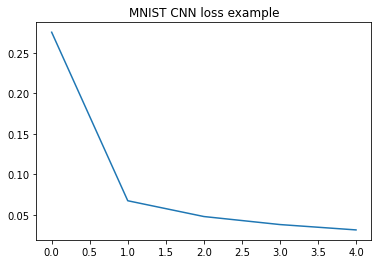

In [53]:
plt.plot(total_loss)
plt.title("MNIST CNN loss example")
plt.show()

**7. Save Model and Load Model to test**

7.1 Save model

In [54]:
torch.save(model.state_dict(),"my_model.pth")   # model의 weight 정보 만을 저장

7.2 Load model

In [55]:
test_model = ConvNetStep().to(device)

test_model.load_state_dict(torch.load("my_model.pth"))   # test_model이라는 모델 안에 앞서 학습한 weight 정보가 담기게 된다.

<All keys matched successfully>

In [56]:
test_model.eval()

with torch.no_grad():
  correct = 0
  
  for img, lab in test_loader:
    img = img.to(device)
    lab = lab.to(device)
    out = test_model(img)
    _, pred = torch.max(out.data, 1)
    correct += (pred == lab).sum().item()

  print("Accuracy of the network on the {} test images: {}%".format(len(test_loader)*batch_size, 100 * correct / (len(test_loader) * batch_size)))

Accuracy of the network on the 10000 test images: 98.87%
